In [1]:
import os
import pickle
import sys
from glob import glob

import climlab
import fedrl_climate_envs
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl"
RECORDS_DIR = f"{BASE_DIR}/records"
DATASETS_DIR = f"{BASE_DIR}/datasets"
IMGS_DIR = f"{BASE_DIR}/results/imgs/"

NUM_STEPS = 200

sys.path.append(BASE_DIR)

In [3]:
fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath,
            decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
).sortby("lat")

lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

climlab_ebm = climlab.EBM_annual(
    A=210, B=2, D=0.6, a0=0.354, a2=0.25, num_lat=96
)
Ts_ncep_annual = Ts_ncep_annual.interp(
    lat=climlab_ebm.lat, kwargs={"fill_value": "extrapolate"}
)
Ts_ncep_annual = np.array(Ts_ncep_annual)
climlab_ebm.Ts[:] = 50
climlab_ebm_obs = []

for i in range(NUM_STEPS):
    climlab_ebm_obs.append(np.array(climlab_ebm.Ts))
    climlab_ebm.step_forward()

climlab_ebm_obs = np.array(climlab_ebm_obs).squeeze()

Loading NCEP surface temperature data ...


In [4]:
import re


def extract_algo(dirname):
    match = re.search(r"inference_([a-z0-9]+)_torch", dirname)
    return match.group(1) if match else None


def get_record_fns(exp_id):
    record_fns = glob(f"{RECORDS_DIR}/inf*{exp_id}_*/*/*_{NUM_STEPS}.pth")
    record_fns = [
        fn
        for fn in record_fns
        if extract_algo(os.path.basename(os.path.dirname(fn))) in ALGOS
    ]
    return record_fns


from multiprocessing import Pool, cpu_count


def get_action_row(record_fn):
    with open(record_fn, "rb") as f:
        exp_id, algo = record_fn.split("/")[-3:-1]
        exp_id = exp_id.split("_")[1]
        seed = int(algo.split("__")[-2])
        algo = algo.split("__")[1].split("_")[1]

        record_steps = torch.load(f)
        actions = record_steps["actions"]
        obs = record_steps["obs"]

        return {
            "exp_id": exp_id,
            "algo": algo,
            "seed": seed,
            "fn": record_fn,
            "actions": actions,
            "obs": obs,
        }


def get_action_rows(record_fns):
    with Pool(processes=cpu_count() - 2) as pool:
        results = list(
            tqdm.tqdm(
                pool.imap_unordered(get_action_row, record_fns),
                total=len(record_fns),
            )
        )
    return [row for row in results if row is not None]


from collections import defaultdict


def get_records(record_fns):
    records = defaultdict(dict)
    for record_fn in record_fns:
        action_row = get_action_row(record_fn)
        algo = action_row["algo"].lower()
        seed = int(action_row["seed"])
        records[algo][seed] = {
            "actions": action_row["actions"],
            "obs": action_row["obs"],
        }
    return records

In [5]:
EXPERIMENT_ID = "ebm-v1-optim-L-20k"
NUM_STEPS = 200
ALGOS = {"tqc", "td3", "ddpg"}

record_fns = get_record_fns(EXPERIMENT_ID)
records = get_records(record_fns)

In [6]:
def plot_TsABOLR(records, exp_id, latitude, algo):

    idx = np.abs(np.array(climlab_ebm.lat) - latitude).argmin()
    latitude = climlab_ebm.lat[idx]
    latitude_dir = f"{abs(latitude):.2f}°{'N' if latitude >= 0 else 'S'}"
    observed_value = Ts_ncep_annual[idx]

    param_bounds = {
        "D": (0.55, 0.65),
        "A": (1.4, 4.2),
        "B": (1.95, 2.05),
        "a0": (0.3, 0.4),
        "a2": (0.2, 0.3),
    }

    def normalise(x, bounds):
        return (x - bounds[0]) / (bounds[1] - bounds[0])

    obs_list = []
    A_list = []
    B_list = []
    OLR_list = []

    for seed, record in records[algo].items():
        obs = record["obs"][:, idx]
        A = record["actions"][:, 1 + idx]
        B = record["actions"][:, 1 + idx + len(climlab_ebm.lat)]
        OLR = A + B * obs

        obs_list.append(obs)
        A_list.append(normalise(A, param_bounds["A"]))
        B_list.append(normalise(B, param_bounds["B"]))
        OLR_list.append(OLR)

    obs_arr = np.stack(obs_list)
    A_arr = np.stack(A_list)
    B_arr = np.stack(B_list)
    OLR_arr = np.stack(OLR_list)

    timesteps = np.arange(obs_arr.shape[1])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 4.8), sharex=True)

    ax1.plot(
        timesteps, obs_arr.mean(axis=0), label="EBM Model w/ RL", color="black"
    )
    ax1.plot(
        timesteps,
        climlab_ebm_obs[:-1, idx],
        label="EBM Model",
        color="black",
        linestyle="--",
    )
    ax1.axhline(observed_value, label="Observed", color="red", linestyle="--")

    ax1.fill_between(
        timesteps,
        obs_arr.mean(axis=0) - (1.96 * obs_arr.std(axis=0) / np.sqrt(10)),
        obs_arr.mean(axis=0) + (1.96 * obs_arr.std(axis=0) / np.sqrt(10)),
        alpha=0.2,
        color="black",
    )
    ax1.set_ylabel("Temperature (°C)", fontsize=12)
    ax1.set_title(f"{algo.upper()} | {latitude_dir}", fontsize=14)
    ax1.legend(fontsize=10)
    ax1.tick_params(axis="both", which="major", labelsize=10)
    ax1.grid(True)

    ax2.plot(timesteps, A_arr.mean(axis=0), label="A")
    ax2.fill_between(
        timesteps,
        A_arr.mean(axis=0) - (1.96 * A_arr.std(axis=0) / np.sqrt(10)),
        A_arr.mean(axis=0) + (1.96 * A_arr.std(axis=0) / np.sqrt(10)),
        alpha=0.2,
    )

    ax2.plot(timesteps, B_arr.mean(axis=0), label="B")
    ax2.fill_between(
        timesteps,
        B_arr.mean(axis=0) - (1.96 * B_arr.std(axis=0) / np.sqrt(10)),
        B_arr.mean(axis=0) + (1.96 * B_arr.std(axis=0) / np.sqrt(10)),
        alpha=0.2,
    )

    ax2.set_ylabel("Normalised [0–1]", fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True)
    ax2.set_xlabel("Timestep", fontsize=12)
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis="both", which="major", labelsize=10)

    plt.tight_layout()

    for ext in ["pdf", "png"]:
        plt.savefig(
            f"{IMGS_DIR}/{ext}/{exp_id}_{algo}_TsABOLR_{latitude_dir.replace('°', '')}.{ext}",
            dpi=300,
            bbox_inches="tight",
        )

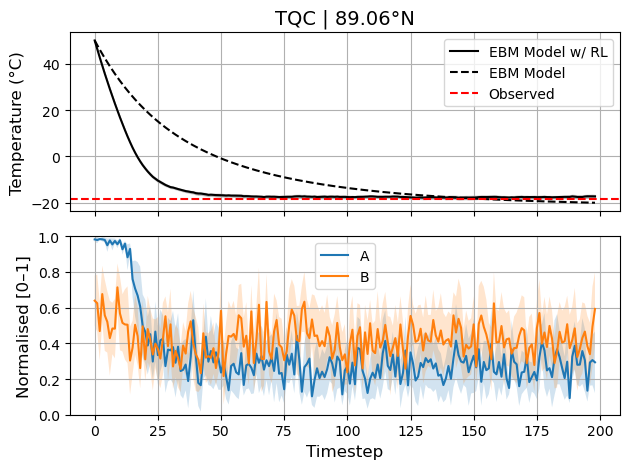

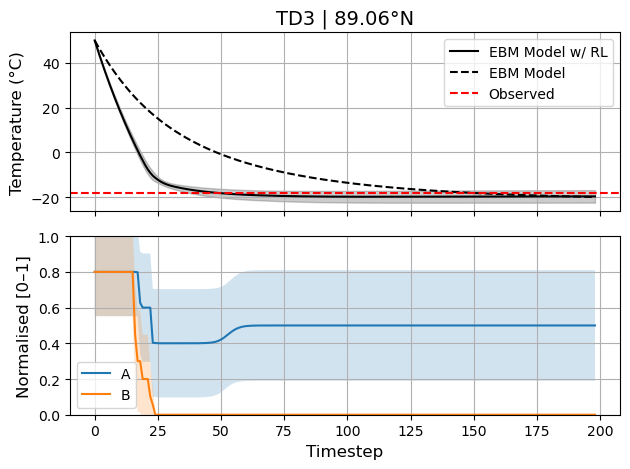

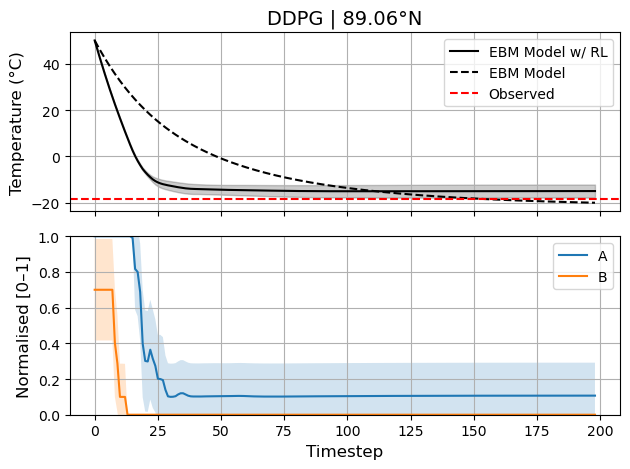

In [7]:
LATITUDE = 90

for algo in ALGOS:
    plot_TsABOLR(records, EXPERIMENT_ID, LATITUDE, algo)

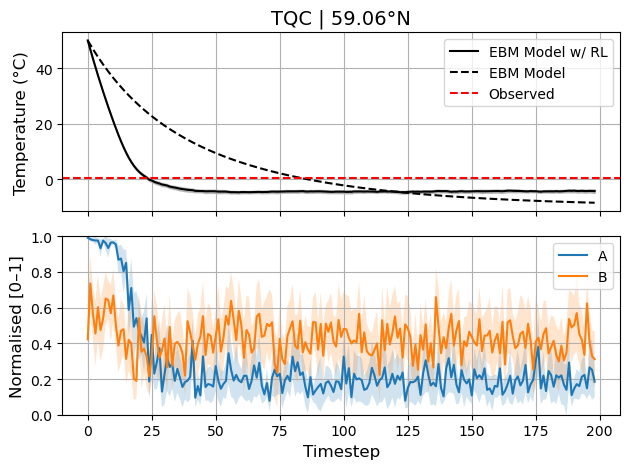

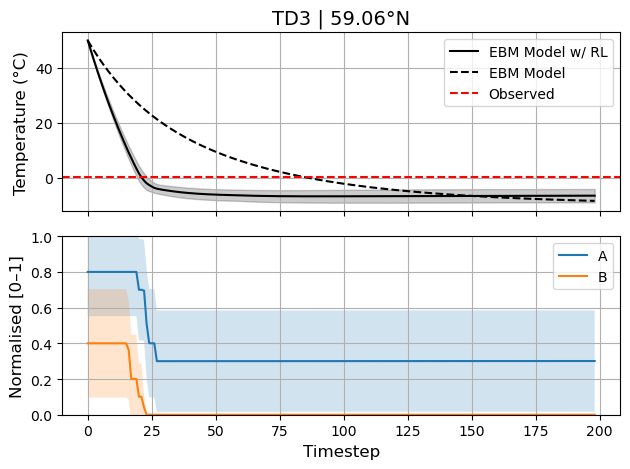

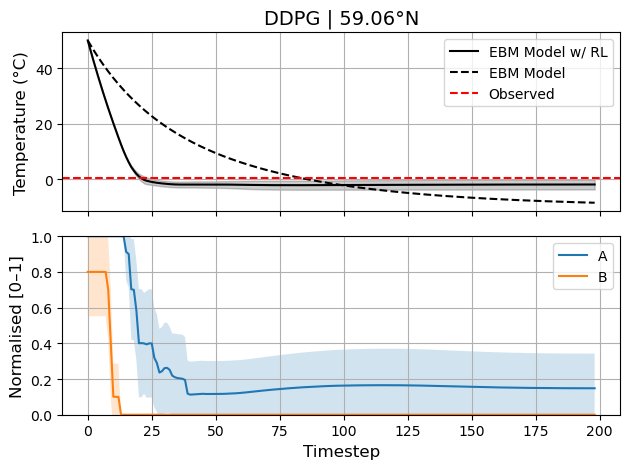

In [8]:
LATITUDE = 60

for algo in ALGOS:
    plot_TsABOLR(records, EXPERIMENT_ID, LATITUDE, algo)

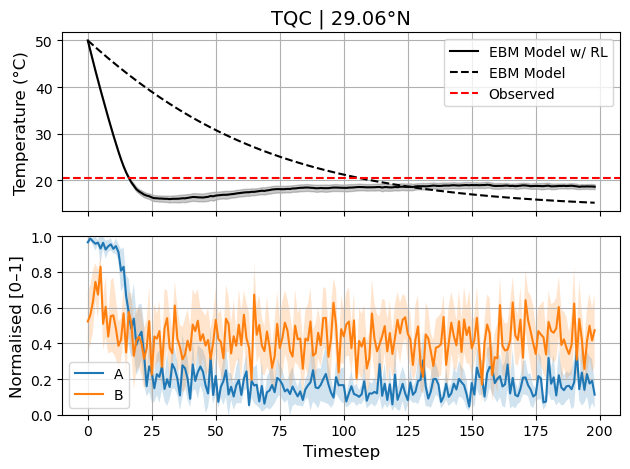

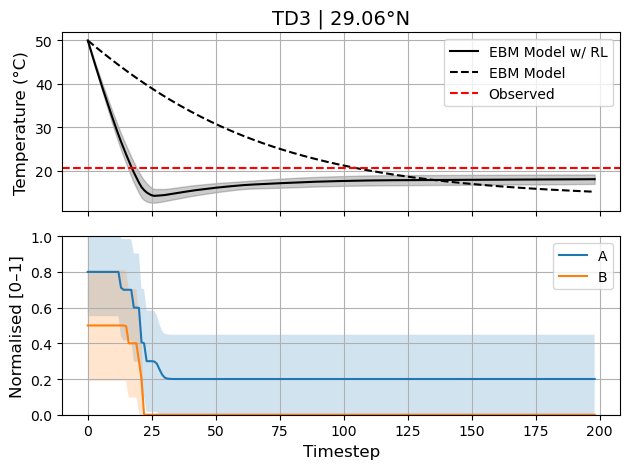

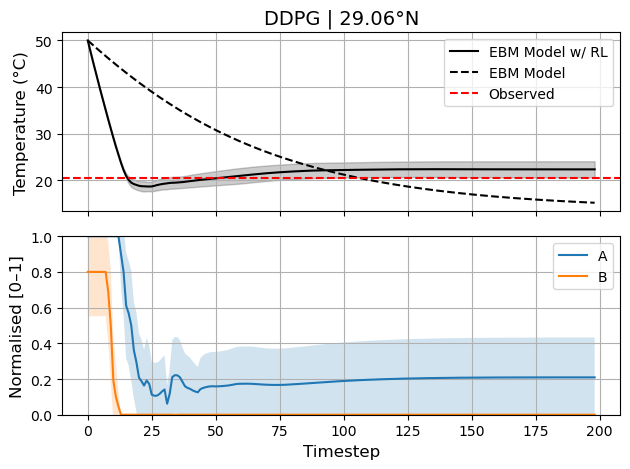

In [9]:
LATITUDE = 30

for algo in ALGOS:
    plot_TsABOLR(records, EXPERIMENT_ID, LATITUDE, algo)

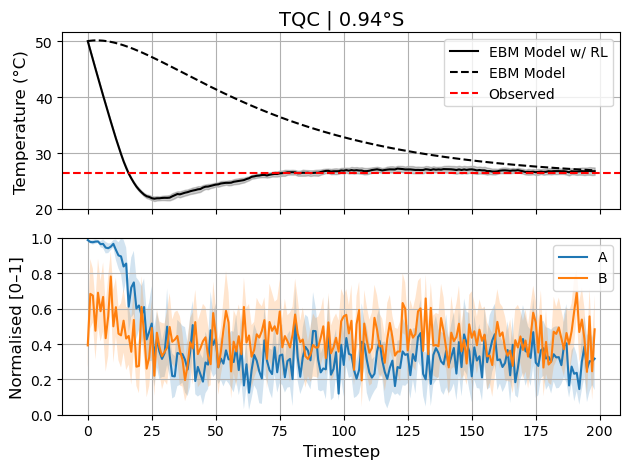

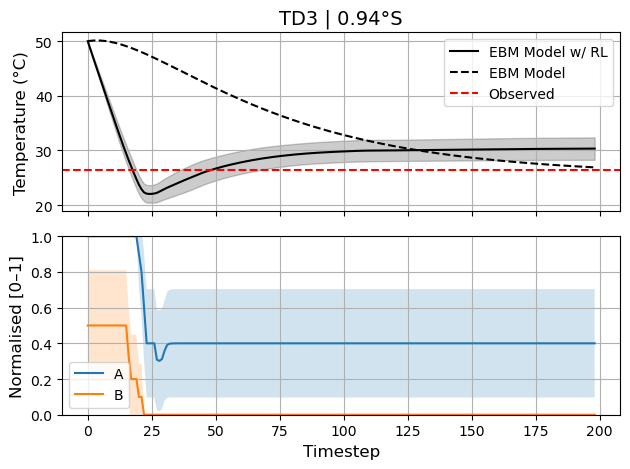

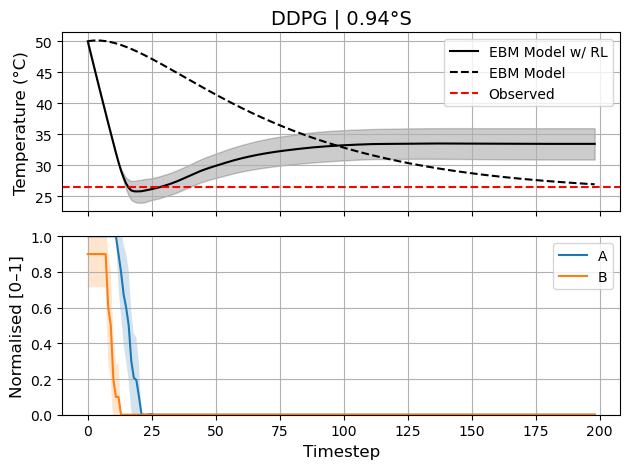

In [10]:
LATITUDE = 0

for algo in ALGOS:
    plot_TsABOLR(records, EXPERIMENT_ID, LATITUDE, algo)

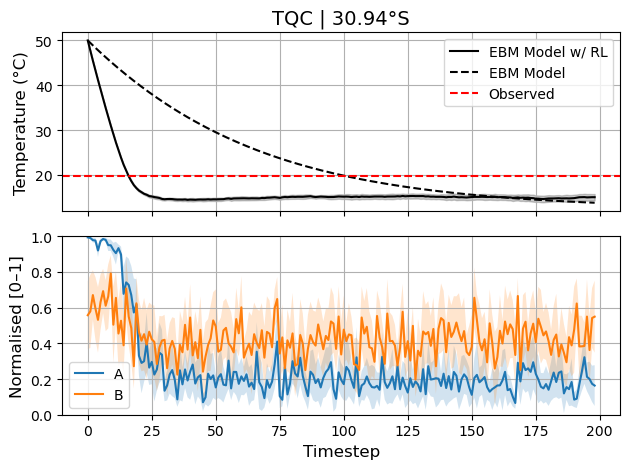

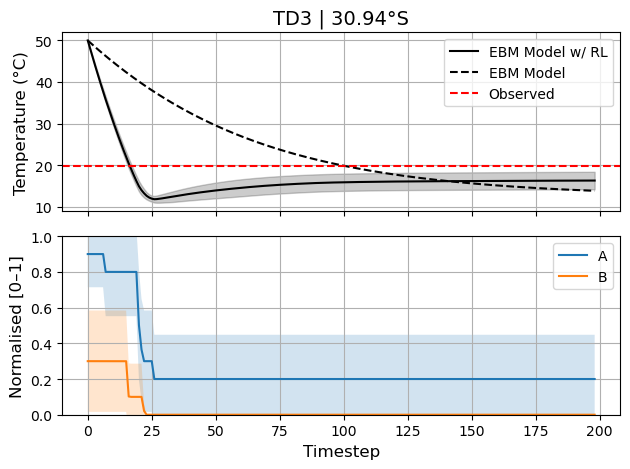

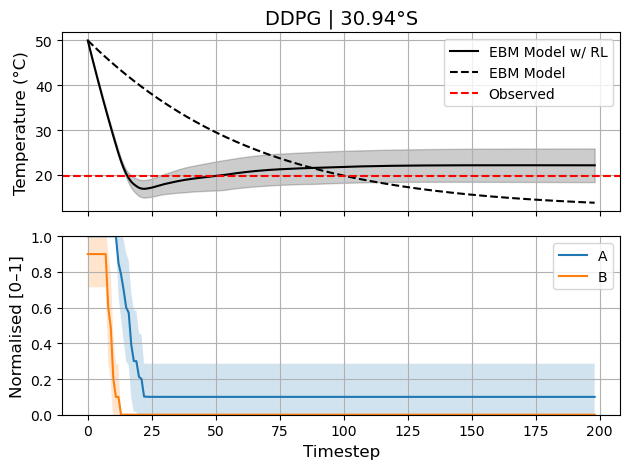

In [11]:
LATITUDE = -30

for algo in ALGOS:
    plot_TsABOLR(records, EXPERIMENT_ID, LATITUDE, algo)

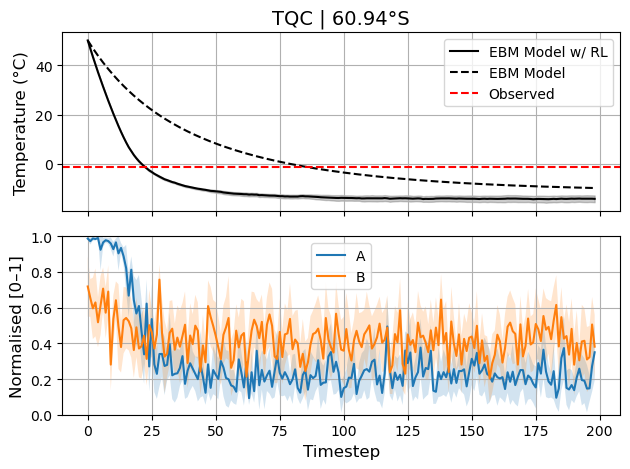

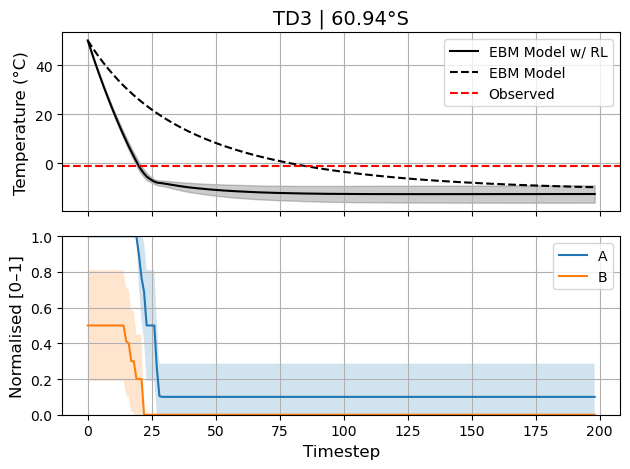

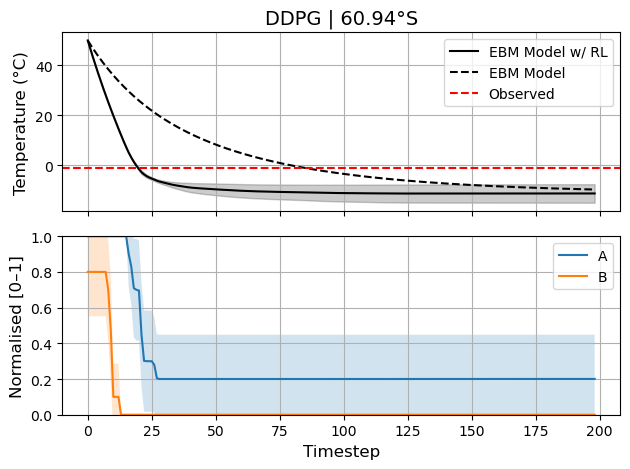

In [12]:
LATITUDE = -60

for algo in ALGOS:
    plot_TsABOLR(records, EXPERIMENT_ID, LATITUDE, algo)

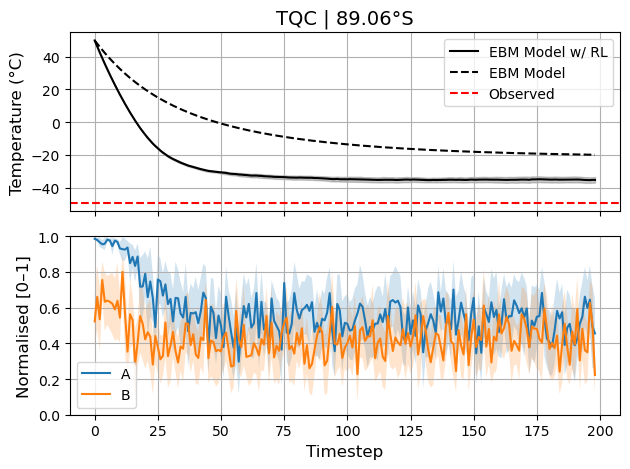

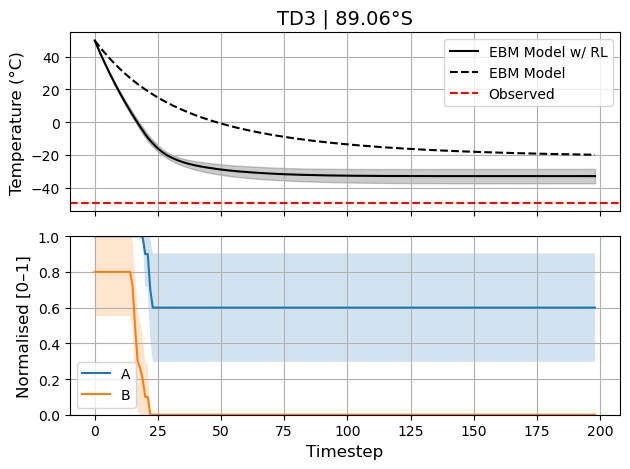

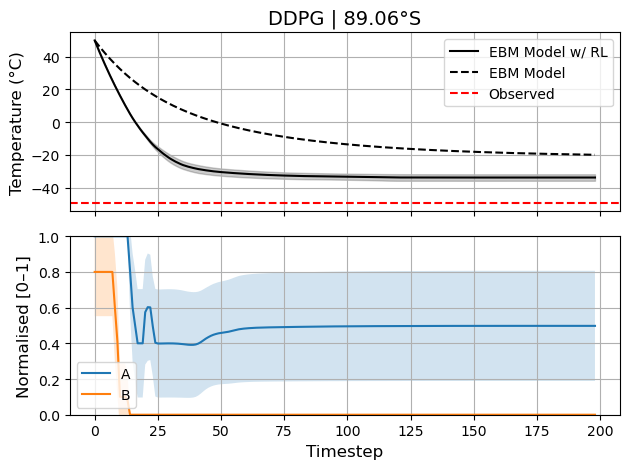

In [13]:
LATITUDE = -90

for algo in ALGOS:
    plot_TsABOLR(records, EXPERIMENT_ID, LATITUDE, algo)